# Job Shop Scheduling

This notebook demonstrates how to model a **Job Shop Scheduling Problem (JSP)**
with `pycsp3-scheduling`.

In a job shop:
- Each job is a sequence of operations.
- Each operation has a fixed machine and processing time.
- Machines can process at most one operation at a time.

We aim to **minimize the makespan** (completion time of the last job).


## Mathematical Model

Let $J$ be jobs and $M$ machines. Each job $j$ has operations $o = 0..O-1$.

Constraints:
- Precedence: $end(j, o) \le start(j, o+1)$
- Machine capacity: operations sharing a machine do not overlap

Objective:
$
\min \max_{j \in J} end(j, O-1)
$


In [1]:
# Imports
from pycsp3 import satisfy, minimize, solve, SAT, OPTIMUM, Maximum, clear
from pycsp3_scheduling import (
    IntervalVar, SequenceVar, SeqNoOverlap,
    end_before_start, end_time, interval_value,
    visu
)
from pycsp3_scheduling.variables.interval import clear_interval_registry

print("Imports successful!")


Imports successful!


## Problem Data

We use a small 3x3 instance (3 jobs, 3 machines). Each job lists
operations as `(machine, duration)` pairs.


In [2]:
# Problem data: jobs[j] = [(machine, duration), ...]
jobs = [
    [(0, 3), (1, 2), (2, 2)],
    [(0, 2), (2, 1), (1, 4)],
    [(1, 4), (2, 3), (0, 2)],
]

n_jobs = len(jobs)
n_ops = len(jobs[0])
n_machines = 1 + max(m for job in jobs for m, _ in job)

assert all(len(job) == n_ops for job in jobs)

machines = [[m for m, _ in job] for job in jobs]
durations = [[d for _, d in job] for job in jobs]

# Simple upper bound on horizon
horizon = sum(sum(d for _, d in job) for job in jobs)

print(f"Jobs: {n_jobs}, Machines: {n_machines}, Ops/job: {n_ops}")
print(f"Horizon upper bound: {horizon}")


Jobs: 3, Machines: 3, Ops/job: 3
Horizon upper bound: 23


## Building the Model


In [3]:
# Reset model state
clear()
clear_interval_registry()

# ops[j][o] is the interval for operation o of job j
ops = [
    [
        IntervalVar(
            start=(0, horizon),
            end=(0, horizon),
            size=durations[j][o],
            name=f"J{j}O{o}_M{machines[j][o]}"
        )
        for o in range(n_ops)
    ]
    for j in range(n_jobs)
]

print("Created interval variables:")
for j in range(n_jobs):
    for o in range(n_ops):
        print(f"  {ops[j][o].name}: machine={machines[j][o]}, size={durations[j][o]}")


Created interval variables:
  J0O0_M0: machine=0, size=3
  J0O1_M1: machine=1, size=2
  J0O2_M2: machine=2, size=2
  J1O0_M0: machine=0, size=2
  J1O1_M2: machine=2, size=1
  J1O2_M1: machine=1, size=4
  J2O0_M1: machine=1, size=4
  J2O1_M2: machine=2, size=3
  J2O2_M0: machine=0, size=2


In [4]:
# Precedence constraints within jobs
satisfy(
    end_before_start(ops[j][o], ops[j][o + 1])
    for j in range(n_jobs)
    for o in range(n_ops - 1)
)

print("Precedence constraints added:")
for j in range(n_jobs):
    chain = " -> ".join(ops[j][o].name for o in range(n_ops))
    print(f"  Job {j}: {chain}")


Precedence constraints added:
  Job 0: J0O0_M0 -> J0O1_M1 -> J0O2_M2
  Job 1: J1O0_M0 -> J1O1_M2 -> J1O2_M1
  Job 2: J2O0_M1 -> J2O1_M2 -> J2O2_M0


In [5]:
# Group operations by machine
machine_ops = [[] for _ in range(n_machines)]
for j in range(n_jobs):
    for o in range(n_ops):
        machine_ops[machines[j][o]].append(ops[j][o])

# Sequence variables for each machine
sequences = [
    SequenceVar(intervals=machine_ops[m], name=f"machine{m}")
    for m in range(n_machines)
]

# No-overlap constraints on machines
satisfy(SeqNoOverlap(seq) for seq in sequences)

print("No-overlap constraints added:")
for m, seq in enumerate(sequences):
    ops_str = ", ".join(iv.name for iv in seq.intervals)
    print(f"  Machine {m}: [{ops_str}]")


No-overlap constraints added:
  Machine 0: [J0O0_M0, J1O0_M0, J2O2_M0]
  Machine 1: [J0O1_M1, J1O2_M1, J2O0_M1]
  Machine 2: [J0O2_M2, J1O1_M2, J2O1_M2]


In [6]:
# Minimize makespan
minimize(Maximum(end_time(ops[j][-1]) for j in range(n_jobs)))

print("Objective: Minimize max(end time of last operation per job)")


Objective: Minimize max(end time of last operation per job)


## Solving


In [7]:
# Solve the problem
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found!" + (" (Optimal)" if result == OPTIMUM else ""))
    print()

    # Extract and display solution
    for j in range(n_jobs):
        print(f"Job {j}:")
        for o in range(n_ops):
            val = interval_value(ops[j][o])
            m = machines[j][o]
            print(f"  Op {o} on M{m}: [{val.start}, {val.end}]")

    makespan = max(interval_value(ops[j][-1]).end for j in range(n_jobs))
    print(f"Makespan: {makespan}")
else:
    print("No solution found")


Solution found! (Optimal)

Job 0:
  Op 0 on M0: [0, 3]
  Op 1 on M1: [4, 6]
  Op 2 on M2: [9, 11]
Job 1:
  Op 0 on M0: [3, 5]
  Op 1 on M2: [5, 6]
  Op 2 on M1: [6, 10]
Job 2:
  Op 0 on M1: [0, 4]
  Op 1 on M2: [6, 9]
  Op 2 on M0: [9, 11]
Makespan: 11


## Visualization

Let's create a Gantt chart showing the schedule:


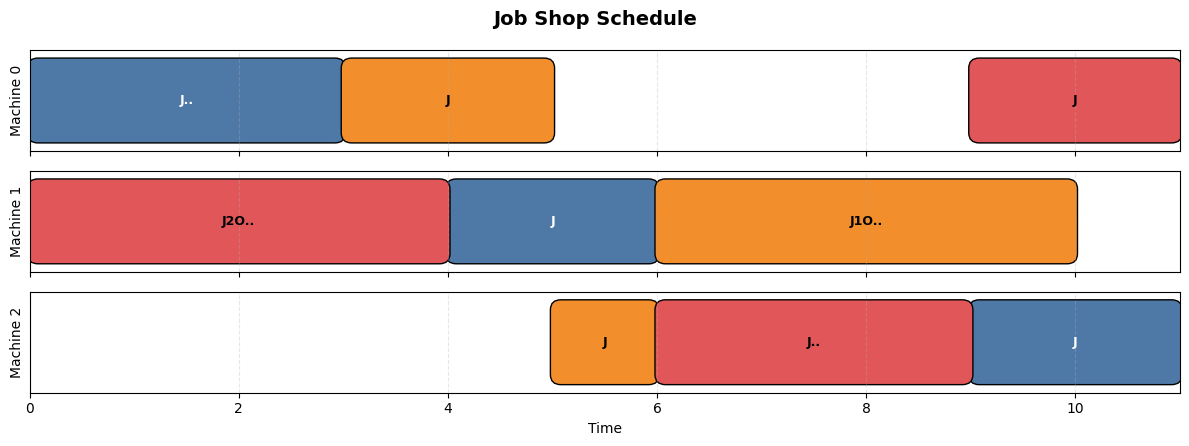

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(ops[j][-1]).end for j in range(n_jobs))
    visu.timeline("Job Shop Schedule", origin=0, horizon=makespan)

    # Create a panel for each machine
    for m in range(n_machines):
        visu.panel(f"Machine {m}")

        # Add all operations assigned to this machine
        for j in range(n_jobs):
            for o in range(n_ops):
                if machines[j][o] == m:
                    val = interval_value(ops[j][o])
                    visu.interval(val, color=j)

    # Show the visualization (requires matplotlib)
    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available)")
        print("\nSchedule summary:")
        for m in range(n_machines):
            print(f"Machine {m}: ", end="")
            schedule = []
            for j in range(n_jobs):
                for o in range(n_ops):
                    if machines[j][o] == m:
                        val = interval_value(ops[j][o])
                        schedule.append((val.start, val.end, j, o))
            schedule.sort()
            for start, end, j, o in schedule:
                print(f"J{j}O{o}[{start},{end}] ", end="")
            print()

## Extensions

### With Setup Times

If there are setup times between different job types, use a transition matrix:


In [9]:
# Example setup time matrix (not used in the model above)
from pycsp3_scheduling import TransitionMatrix

# Define job types
job_types = [0, 1, 0]  # Job 0 and 2 are type 0, Job 1 is type 1

# Setup time matrix: setup[from_type][to_type]
setup_times = TransitionMatrix([
    [0, 5],  # From type 0: to type 0 = 0, to type 1 = 5
    [3, 0],  # From type 1: to type 0 = 3, to type 1 = 0
])

print("Setup time matrix:")
print(f"  Type 0 -> Type 0: {setup_times[0, 0]}")
print(f"  Type 0 -> Type 1: {setup_times[0, 1]}")
print(f"  Type 1 -> Type 0: {setup_times[1, 0]}")
print(f"  Type 1 -> Type 1: {setup_times[1, 1]}")

# To use in the model:
# types = [job_types[j] for j in range(n_jobs) for o in range(n_ops) if machines[j][o] == m]
# seq = SequenceVar(intervals=machine_ops[m], types=types, name=f"M{m}")
# satisfy(SeqNoOverlap(seq, transition_matrix=setup_times.matrix))


Setup time matrix:
  Type 0 -> Type 0: 0
  Type 0 -> Type 1: 5
  Type 1 -> Type 0: 3
  Type 1 -> Type 1: 0
